In [1]:
#Importing packages we need
import numpy as np
import matplotlib.pyplot as plt #pyplot is used to plot the data
import scipy.optimize as opt #used to numerically optimize
from datetime import time, timedelta, datetime
import numdifftools as nd #Using this package to numerically approximate the hessian matrix

In [2]:
#Transform 'parameters' vector to SSF parameters.
def ParToSSF(parameters):
    #Transform elements of 'parameters' vector into A, Omega_W, Phi and Omega_v.
    A=np.ones([1,2])    #not to be estimated
    Phi = np.zeros([2,2])
    Phi[1,1]=1  
    Phi[0,0]=parameters[2] #Only element 1,1 holds parameters.
    
    Omega_w=(np.pi**2)/8  #not to be estimated
    
    Omega_v=np.zeros([2,2])
    Omega_v[0,0] = (parameters[1]**2)*(1-parameters[2]**2) # Only element 1,1 holds parameters.
    
    #Return SSF parameters.
    return A, Omega_w, Phi, Omega_v

def KalmanFilter(A,Omega_w,Phi,Omega_v,X_filt_lag,Omega_filt_lag,Zt):
    #Define identity matrix.
    T=len(X_filt_lag)
    I=np.identity(T)
    #Prediction step.
    X_pred = Phi.dot(X_filt_lag) #(VI.9)
    Omega_pred = Phi.dot(Omega_filt_lag).dot(Phi.T) + Omega_v #(VI.10)
    #Kalman gain.
    K = Omega_pred.dot(A.T).dot(np.linalg.inv(A.dot(Omega_pred).dot(A.T) + Omega_w)) #(VI.13)

    #Filter step.
    X_filt = X_pred + K.dot(Zt - A.dot(X_pred)) #(VI.11)
    Omega_filt = (I - K.dot(A)).dot(Omega_pred) #(VI.12)
   
    #Return array with predicted and filtered state.
    res=np.zeros([2,2])
    return X_pred, Omega_pred, X_filt, Omega_filt #predicted state, filtered state

def KalmanLogLik(A,Omega_w,Phi,Omega_v,X_0,Omega_0,Z):
    #Determine sample and state size.
    T = len(Z)
    #Allocate space.
    logLik_vec = np.zeros(T)

    #Kalman recursions.
    X_filt_lag = X_0
    Omega_filt_lag = Omega_0
    logLike_vec=np.zeros(T)
    for t in range(T):
        #Obtain predicted and filtered state.
        X_pred, Omega_pred, X_filt, Omega_filt = KalmanFilter(A, Omega_w, Phi, Omega_v, X_filt_lag, Omega_filt_lag, Z[t])
        #Calculate the expectation and variance of Z_t.
        Z_pred_exp = A.dot(X_pred) #(VI.19)
        et=Z[t] - Z_pred_exp #(VI.19)
        Z_pred_var = A.dot(Omega_pred).dot(A.T) + Omega_w  #(VI.20)

        #// Calculate the log-likelihood contribution for period t via
        #the prediction-error decomposition, cf. summands of (VI.22).
        logLike_vec[t]=-np.log(np.pi)-np.log(np.linalg.det(Z_pred_var))-(et.T).dot(np.linalg.inv(Z_pred_var)).dot(et)
        logLike_vec[t]=0.5*logLike_vec[t]
        #Save denote filtered state as 'lag' for use in next recursion.
        X_filt_lag = X_filt
        Omega_filt_lag = Omega_filt
    
    # Return average log-likelihood value.
    return 1/T*np.sum(logLike_vec)


In [3]:
#Log-likelihood function for log-SV model.
def SV_Likelihood(parameters): 
    #Transform 'parameters' vector to SSF parameters.
    A, Omega_w, Phi, Omega_v = ParToSSF(parameters)
    
    #// Set initial values of state.
    X_0=np.zeros([2,1])
    X_0[0]  = np.log(np.var(y[1:]))/2 - parameters[0]
    X_0[1] = parameters[0] - 0.63518
    
    Omega_0=np.zeros([2,2])
    Omega_0[0,0]=10**6
    
    #Call KalmanLogLik function from KalmanFilter package to calculate the
    #average log-likelihood value via the prediction-error decomposition.
    logLik = KalmanLogLik(A, Omega_w, Phi, Omega_v, X_0, Omega_0, Z)
    
    #Return logLik.
    return -logLik #notice we are going to minimize the likelihood function

In [4]:
#getting data
#Locate my folder
folder='Insert your folder path xD' #remember it is written with "/" seperators like 'C:/Users/...' 
data=np.genfromtxt(folder+'SP500.csv', delimiter=',',usecols=np.arange(0,4)) #loading in first 4 columns
y = data[15097:, 3:4] # log-returns of the S&P 500 index. January 4, 2010 - till end
y=y.T[0,:] #unpacking numpy array
T = len(y) #length of time series
#Load transformed data to global variable.
Z = np.log(np.abs(y[1:]))
#Initial parameters.
par = np.array([-5.00,0.28,0.93]) #alpha, beta,phi

In [5]:
res=opt.minimize(SV_Likelihood, par, method='SLSQP',bounds=((None,None),(None,None),(-0.9999,0.9999))) #optimizing. We use L-BFGS-B as it allows for bounds and can compute the standard errors (from the inverse hessian) right away
par_hat=res.x
par_hat

array([-4.91257282,  0.5110162 ,  0.92293569])

In [6]:
H = nd.Hessian(SV_Likelihood)(par_hat) #Approximating the hessian numerically evaluated at the parameter estimates
H = -H #finding hessian (remember we minimized so the Hessian is the minus of the result given by H)
#Neglect the warning message in this case

C:\Users\vjule\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in log
C:\Users\vjule\Anaconda3\lib\site-packages\numdifftools\extrapolation.py:489: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
C:\Users\vjule\Anaconda3\lib\site-packages\numdifftools\limits.py:173: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
C:\Users\vjule\Anaconda3\lib\site-packages\numdifftools\limits.py:174: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
C:\Users\vjule\Anaconda3\lib\site-packages\numdifftools\limits.py:175: RuntimeWarning: invalid value encountered in less
  ((der < p25 - 1.5 * iqr) + (p75 + 1.5 * iqr < der)))


In [7]:
#Calculate the Information (Recall we use average loglik, hence we now scale with T).
Information=np.linalg.inv(-H)/T
#Calculate the standard errors.
se_H=np.sqrt(np.diagonal(Information))

In [8]:
print('Hessian')
print(H)
print('Information')
print(Information)

Hessian
[[-0.12813891  0.0014719   0.0037741 ]
 [ 0.0014719  -0.25809264 -0.05380471]
 [ 0.0037741  -0.05380471 -0.93002378]]
Information
[[ 5.43169051e-03  2.67037354e-05  2.04972809e-05]
 [ 2.67037354e-05  2.72934366e-03 -1.57792490e-04]
 [ 2.04972809e-05 -1.57792490e-04  7.57466184e-04]]


In [9]:
print('Parameters with standard errors')
alp_est=res.x[0]
beta_est=res.x[1]
phi_est=res.x[2]
print('Estimates are given by with std. errors in ():')
print('alpha= '+str(alp_est)+', (' +str(se_H[0])+')' )
print('beta= '+str(beta_est)+', (' +str(se_H[1])+')' )
print('phi= '+str(phi_est)+', (' +str(se_H[2])+')' )

Parameters with standard errors
Estimates are given by with std. errors in ():
alpha= -4.912572821411182, (0.0737000034404895)
beta= 0.5110162049978316, (0.05224312066931052)
phi= 0.9229356926631865, (0.027522103546176045)


In [10]:
#Filter and display stochastic volatility.
#setting parameters equal to estimated parameters
parameters=par_hat
T=len(Z)
logSigma = np.zeros(T)
logSigma_stddev = np.zeros(T)
#Transform 'parameters' vector to SSF parameters.
A, Omega_w, Phi, Omega_v = ParToSSF(parameters)

X_0=np.zeros([2,1])
X_0[0]  = np.log(np.var(y[1:]))/2 - parameters[0]
X_0[1] = parameters[0] + 0.63518

Omega_0=np.zeros([2,2])
Omega_0[0,0]=10**6

#Kalman recursions.
X_filt_lag = X_0
Omega_filt_lag = Omega_0
for t in range(T):
    #Obtain predicted and filtered state.
    X_pred, Omega_pred, X_filt, Omega_filt = KalmanFilter(A, Omega_w, Phi, Omega_v, X_filt_lag, Omega_filt_lag, Z[t])
    
    #Store log-sigma and its standard error
    logSigma[t]=X_filt[0]+par[0]
    logSigma_stddev[t]=Omega_filt[0,0]
    
    #Save denote filtered state as 'lag' for use in next recursion.
    X_filt_lag = X_filt
    Omega_filt_lag = Omega_filt

(0, 1436)

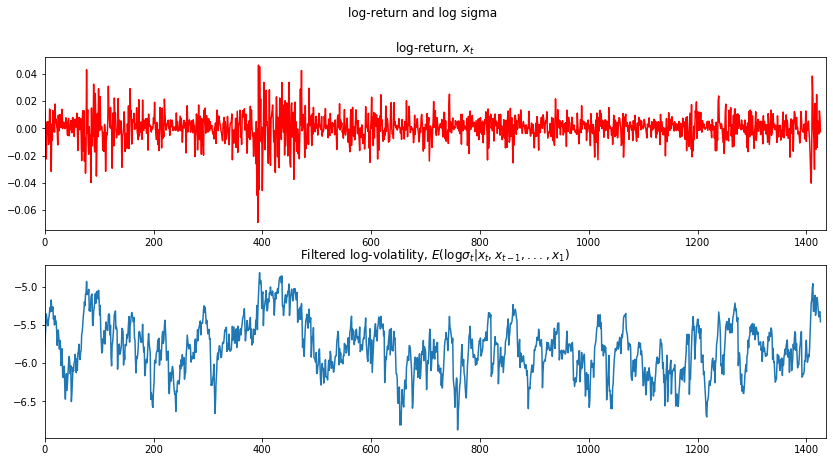

In [11]:
fig, ax=plt.subplots(2, figsize=(14,7))
#fig.set_figheight=(9)
#fig.set_figwidth=(16)
fig.suptitle('log-return and log sigma')
ax[0].plot(y[10:],color='r')
ax[1].plot(logSigma[9:])

#Setting titles
ax[0].title.set_text("log-return, $x_t$")
ax[1].title.set_text("Filtered log-volatility, $E(\log\sigma_t|x_{t},x_{t-1},...,x_{1})$")

ax[0].set_xlim(0, T)
ax[1].set_xlim(0, T)
